## Introduction ##

This notebook is written in Python. It is my solution to the Kaggle.com Titanic competition (kaggle.com/c/titanic). It generated a top 19% result. 

###Question and problem definition###

"On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. "

"In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy."

##Variable	Definition##	
survival	Survival	
pclass	    Ticket class	
sex	        Sex	
Age	        Age in years	
sibsp	    # of siblings / spouses aboard the Titanic	
parch	    # of parents / children aboard the Titanic	
ticket	    Ticket number	
fare	    Passenger fare	
cabin	    Cabin number	
embarked	Port of Embarkation	

0 = No, 1 = Yes
1 = 1st, 2 = 2nd, 3 = 3rd
C = Cherbourg, Q = Queenstown, S = Southampton


Steps:

 1. Explore and visualize the data.
 2. Feature engineering and imputing missing data
 3. Prediction using an ensemble method


In [1]:
#Import libraries and data

import numpy as np
import pandas as pd
import seaborn as sns
import re as re
import matplotlib.pyplot as plt

%matplotlib inline


train = pd.read_csv('../titanic/train.csv')
test = pd.read_csv('../titanic/test.csv')

full_data = [train, test]

#Exploring the data#

In [2]:
print(train.head())
train.describe()
train.info()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

Notes:

 - Check if PassengerID can be dropped 
 - Create family size column 
 - Create solo traveller column 
 - Create title column

##PassengerId##

In [3]:
from numpy import corrcoef

corrcoef(train["PassengerId"], train["Survived"])

array([[ 1.        , -0.00500666],
       [-0.00500666,  1.        ]])

In [4]:
#drop passenger id

train = train.drop('PassengerId', 1)
test = test.drop('PassengerId', 1)

## Sex ##

In [5]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## SibSp and Parch ##

SibSp = # of siblings / spouses aboard the Titanic

Parch = # of parents / children aboard the Titanic

It seems likely that family size will influence survival rates. I will create a family size column. 

In [6]:
print (train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


In [7]:
train["Famsize"] = train["Parch"]+ train["SibSp"]+1
test["Famsize"] = test["Parch"]+ test["SibSp"]+1


print (train[["Famsize", "Survived"]].groupby(['Famsize'], as_index=False).count())

   Famsize  Survived
0        1       537
1        2       161
2        3       102
3        4        29
4        5        15
5        6        22
6        7        12
7        8         6
8       11         7


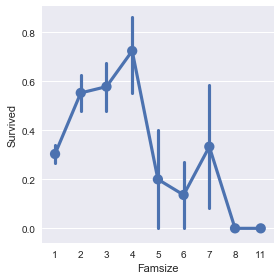

In [8]:
sns.factorplot(x="Famsize", y="Survived", data=train)

##Lone Child##

Are children travelling alone, who are teenagers or travelling with a nanny, more likely to survive? Are there enough passengers in this category to make it a worthwhile measure?

In [9]:
#No parents

print(train.loc[(train["Parch"]==0) & (train["Age"]<18)])

train["LoneChild"] = 0
train.loc[(train["Parch"]==0) & (train["Age"]<18), "LoneChild"] = 1

     Survived  Pclass                                               Name  \
9           1       2                Nasser, Mrs. Nicholas (Adele Achem)   
14          0       3               Vestrom, Miss. Hulda Amanda Adolfina   
22          1       3                        McGowan, Miss. Anna "Annie"   
39          1       3                        Nicola-Yarred, Miss. Jamila   
84          1       2                                Ilett, Miss. Bertha   
111         0       3                               Zabour, Miss. Hileni   
114         0       3                              Attalah, Miss. Malake   
125         1       3                       Nicola-Yarred, Master. Elias   
138         0       3                                Osen, Mr. Olaf Elon   
156         1       3                   Gilnagh, Miss. Katherine "Katie"   
163         0       3                                    Calic, Mr. Jovo   
208         1       3                          Carr, Miss. Helen "Ellen"   
220         

   LoneChild  Survived
0          0  0.379511
1          1  0.500000


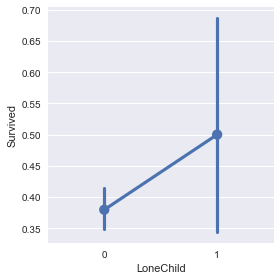

In [10]:
print (train[["LoneChild", "Survived"]].groupby(['LoneChild'], as_index=False).mean())
sns.factorplot(x="LoneChild", y="Survived", data=train)

Conclusion: 
Not a useful measure

In [11]:
train = train.drop("LoneChild", 1)

##Alone##

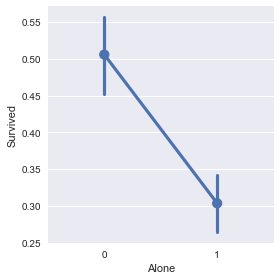

In [13]:
train['Alone'] = 0
train.loc[train['Famsize'] == 1, 'Alone'] = 1

test['Alone'] = 0
test.loc[test['Famsize'] == 1, 'Alone'] = 1
    
sns.factorplot(x="Alone", y="Survived", data=train)

## Embarked ##
The embarked feature has some missing value. and we try to fill those with the most occurred value ( 'S' ).

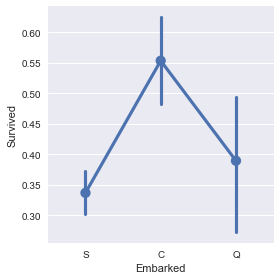

In [14]:
sns.factorplot('Embarked','Survived', data=train)

In [15]:
print("Mean")
print (train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())

print("Count")
print (train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).count())

Mean
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
Count
  Embarked  Survived
0        C       168
1        Q        77
2        S       644


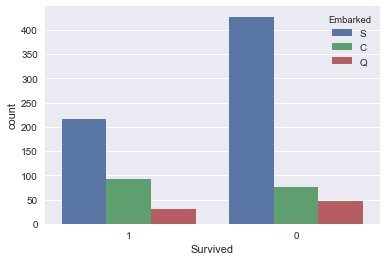

In [16]:
sns.countplot(x='Survived', hue="Embarked", data=train, order=[1,0])

In [17]:
#fill in missing values with median value

train["Embarked"][train["Embarked"].isnull()] = 'S'
test["Embarked"][test["Embarked"].isnull()] = 'S'

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [18]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famsize,Alone


In [19]:
train['Embarked'].fillna('S')

0      S
1      C
2      S
3      S
4      S
5      Q
6      S
7      S
8      S
9      C
10     S
11     S
12     S
13     S
14     S
15     S
16     Q
17     S
18     S
19     C
20     S
21     S
22     Q
23     S
24     S
25     S
26     C
27     S
28     Q
29     S
      ..
861    S
862    S
863    S
864    S
865    S
866    C
867    S
868    S
869    S
870    S
871    S
872    S
873    S
874    C
875    C
876    S
877    S
878    S
879    C
880    S
881    S
882    S
883    S
884    S
885    Q
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, dtype: object

In [20]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

  CategoricalFare  Survived
0       [0, 7.91]  0.197309
1  (7.91, 14.454]  0.303571
2    (14.454, 31]  0.454955
3   (31, 512.329]  0.581081


## Age ##
Need to fill missing values.

In [33]:
for dataset in [train, test]:
    avg_age = dataset['Age'].mean()
    std_age = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    random_age = np.random.randint(avg_age - std_age, avg_age + std_age, size=age_null_count)
    dataset['Age'][dataset['Age'].isnull()] = random_age
    dataset['Age'] = dataset['Age'].astype(int)
    

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:

np.corrcoef(train["Age"], train["Survived"])

array([[ 1.        , -0.07176934],
       [-0.07176934,  1.        ]])

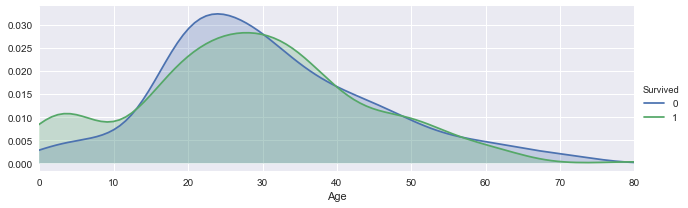

In [29]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

## 7. Name ##
inside this feature we can find the title of people.

In [32]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
    if title_search:
		return title_search.group(1)
    return ""

for dataset in [train, test]:
    dataset['Title'] = dataset['Name'].apply(get_title)

print pd.crosstab(train['Title'], train['Sex'])

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


 so we have titles. let's categorize it and check the title impact on survival rate.

In [36]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

       Title  Survived
0       Capt  0.000000
1        Col  0.500000
2   Countess  1.000000
3        Don  0.000000
4         Dr  0.428571
5   Jonkheer  0.000000
6       Lady  1.000000
7      Major  0.500000
8     Master  0.575000
9       Miss  0.697802
10      Mlle  1.000000
11       Mme  1.000000
12        Mr  0.156673
13       Mrs  0.792000
14        Ms  1.000000
15       Rev  0.000000
16       Sir  1.000000


#Data cleaning#


In [37]:
#encoding categorical variable

from sklearn.preprocessing import LabelEncoder

categories = ['Embarked','Sex','Title']

for cat in categories:
    train[cat] = LabelEncoder().fit_transform(train[cat])
    test[cat] = LabelEncoder().fit_transform(test[cat])

In [39]:
#dropping irrelevant columns

drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch']

train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

In [ ]:
#Classification#

In [ ]:
#Comparing algorithms

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    [KNeighborsClassifier(3),'KNN'],
    [SVC(probability=True), 'SVC'],
    [DecisionTreeClassifier(),'Decision Tree'],
    [RandomForestClassifier(),'Random Forest'],
    [AdaBoostClassifier(),'ADA booster'],
    [GradientBoostingClassifier(),'Gradient Booster'],
    [GaussianNB(),'Gaussian Nb'],
    [LinearDiscriminantAnalysis(),'Linear Discriminant Analysis'],
    [QuadraticDiscriminantAnalysis(),'Quadratic Discrimination'],
    [LogisticRegression(),'Logistic Regression']]


X = train.drop("Survived",axis=1)
y = train["Survived"]
X_test  = test



scores = []

for clf in classifiers:
    
    clf = clf[0]
    
    clf.fit(X,y)
    y_pred = clf.predict(X_test)
    
    cv_scores = cross_val_score(clf, X, y, cv=5)

    #score = clf.score(X,y)
    scores.append(cv_scores.mean())
    

In [ ]:
#viewing classifier scores

names = [clf[1] for clf in classifiers]


np.column_stack((names, scores))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

test["PassengerId"] = test["PassengerId"].astype(int)

predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Famsize", "Title", "Alone"]

algorithms = [GaussianNB(), LinearDiscriminantAnalysis(), GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3),
LogisticRegression(random_state=1),RandomForestClassifier(random_state=1, n_estimators = 50, min_samples_split=4, min_samples_leaf=2)]


predictions = []
train_target = train["Survived"]
full_test_predictions = []

    # Make predictions for each algorithm on each fold
for alg in algorithms:
        # Fit the algorithm on the training data
    alg.fit(train[predictors], train_target)
        # Select and predict on the test fold 
        # We need to use .astype(float) to convert the dataframe to all floats and avoid an sklearn error
    test_predictions = alg.predict_proba(test[predictors])[:,1]
    full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme&#8212;just average the predictions to get the final classification
test_predictions = ( sum(full_test_predictions) / len(full_test_predictions) )
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction
test_predictions[test_predictions <= .5] = 0
test_predictions[test_predictions > .5] = 1
predictions.append(test_predictions)

# Put all the predictions together into one array
predictions = np.concatenate(predictions, axis=0).astype(int)



submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv('titanic-predictions-5.csv', index = False)